# Multilayer Perceptrons in PyTorch

In this example I'll create a feedforward neural network, often loosely termed a multilayer perceptron (MLP), and illustrate how we can train the parameters of the MLP using SGD.

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting
import matplotlib.colors as mcol

import numpy as np

from scipy.stats import multivariate_normal as mvn
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.nn.functional as F

# Utility to visualize PyTorch network and shapes
from torchsummary import summary

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)
torch.manual_seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

## Non-linearly Separable Problem

A problem of using single artificial neurons without hidden layers is their limited capacity to separate data that is not linearly separable. For instance, let's consider a neuron modelled as a <b>perceptron</b>, also known as the heaviside step function or linear threshold function:

\begin{equation}
g(a) = \begin{cases}
          1 \quad &\text{if} \, a \geq 0 \\
          0 \quad &\text{otherwise} \\
     \end{cases}
\end{equation}

where $a$ are our <b>pre-activation</b> values. Without any hidden layers, these pre-activations would simply be a linear combination of the inputs $\mathbf{x}$ with their connection weights $\mathbf{w}$ and a bias term $b$ (often written as $w_0$ in previous notes, but standard with neural networks to see the symbol $b$ for bias), such that $a(\mathbf{x}) = \mathbf{w}^\intercal \mathbf{x} + b$.

The above perceptron is an <b>activation function</b>, but you can also consider another one you know - the sigmoid:

$$g(a) = \frac{1}{1 + e^{-a}} = \frac{e^a}{e^a + 1}.$$

A prevalent way of illustrating the issue of using single neurons to model data with non-linearly separable regions, is the XOR logic gate problem. For inputs $x_1$ and $x_2$, this has the following truth table:

| x1 | x2 | XOR(x1,x2) |
|:-:|:-:|:--------:|
| 0 | 0 | 0        |
| 0 | 1 | 1        |
| 1 | 0 | 1        |
| 1 | 1 | 0        |

If we plot this function for the two input values, as can be seen in the below cell of code, then it is clear that we cannot draw a single line that separates out the 0 and 1s.

Instead, the below code looks at an MLP that transforms the inputs into a representation that leads to a linearly separable form of the XOR gate problem.

See references for where [code snippet](https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book1/13/xor_heaviside.ipynb) below was adapted from.

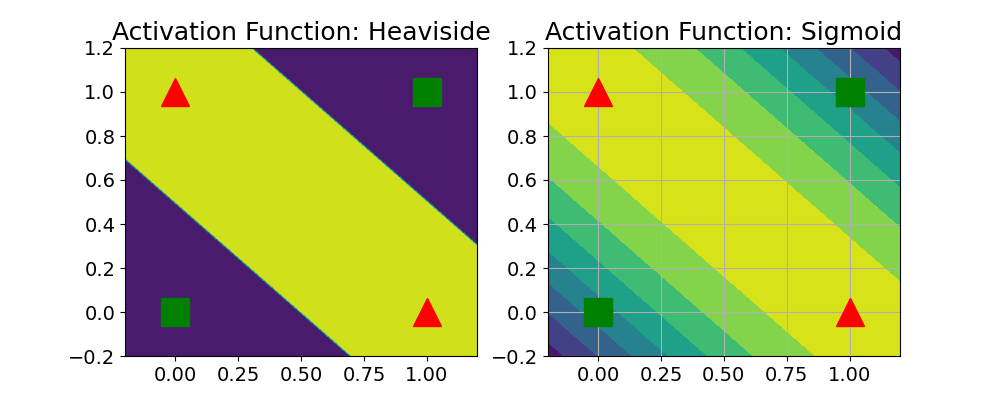

In [2]:
# Perceptron 
def heaviside(a):
    return (a >= 0).astype(a.dtype)

# Logistic/Sigmoid
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

# MLP for the XOR gate, where we assume we know the weights and bias terms to define our decision boundaries
def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)


# Create a grid of coordinates over the input space
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

# Single artificial neuron
z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
cs1 = plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "r^", markersize=20)
plt.title("Activation Function: Heaviside")

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "r^", markersize=20)
plt.title("Activation Function: Sigmoid")
plt.grid(True)
plt.show()

### Dataset

That previous XOR gate function is a toy example, but why not consider the case where maybe you have a training dataset $\mathcal{D}_train = \{(\mathbf{x}^{(i)}, y^{(i)})\}_{i=1}^N$, where $\mathbf{x} \in \mathbb{R}^2$ is two-dimensional and there are three classes $C=3$, such that $y \in \{0, 1, 2\}$. 

Let's sample from five multivariate Gaussians and color-code the individual components based on their labels to specify this dataset:

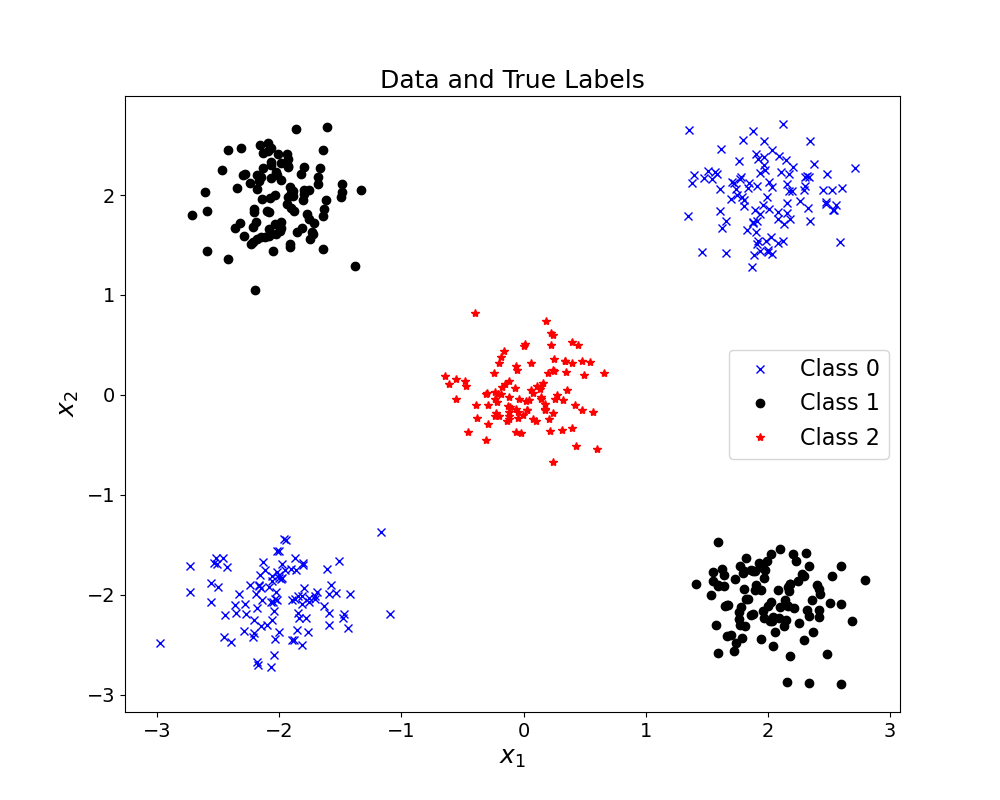

In [3]:
N = 100

def create_data(N, noise=0.1):
    # Uses the same covariance matrix, scaled identity, for all Gaussians
    Sigma = noise * np.eye(2)
    # Five gaussian means specified to span a square and its centre
    gaussians = [
        mvn(mean=[2, 2], cov=Sigma),
        mvn(mean=[-2, -2], cov=Sigma),
        mvn(mean=[2, -2], cov=Sigma),
        mvn(mean=[-2, 2], cov=Sigma),
        mvn(mean=[0, 0], cov=Sigma),
    ]
    # Draw random variable samples and assign labels, note class 3 has less samples altogether
    X = np.concatenate([g.rvs(size=N) for g in gaussians])
    y = np.concatenate((np.zeros(N), np.zeros(N), np.ones(N), np.ones(N), 2 * np.ones(N)))
    
    # Will return an X and y of shapes (5*N, 2) and (5*N)
    # Representing our dataset of 2D samples
    return X, y


X, y = create_data(N)
C = len(np.unique(y))

plt.figure(figsize=(10,8))
plt.plot(X[y==0, 0], X[y==0, 1], 'bx', label="Class 0")
plt.plot(X[y==1, 0], X[y==1, 1], 'ko', label="Class 1");
plt.plot(X[y==2, 0], X[y==2, 1], 'r*', label="Class 2");
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Data and True Labels")
plt.legend()
plt.show()

## Multinomial Logistic Regression

Before proceeding with MLPs, let's cover a quick point on multinomial (multi-class) logistic regression. Recall that for binary logistic regression, the model was a Bernoulli: 

\begin{align*}
P(y \, | \, \mathbf{x}; \boldsymbol{\theta}) & = \text{Ber}\left(y \, | \, g(\mathbf{w}^\intercal \mathbf{x} + b)\right) \\
 & = g\left(\mathbf{w}^\intercal \mathbf{x} + b\right)^y \left(1-g(\mathbf{w}^\intercal \mathbf{x} + b)\right)^{(1-y)},
\end{align*}

where $g(a)$ is the sigmoid function defined above, $\mathbf{x} \in \mathbb{R}^n$ the inputs, $\mathbf{w} \in \mathbb{R}^n$ the weights vector and $b \in \mathbb{R}$ the bias term.

In the multi-class case, we instead model a [Categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution):

\begin{equation*}
P(y \, | \, \mathbf{x}; \boldsymbol{\theta}) = \text{Cat}\left(y \, | \, S(\mathbf{W}^\intercal \mathbf{x} + \mathbf{b})\right) 
\end{equation*}

where the pmf for a categorical distribution is:

\begin{equation*}
P(y = c \, | \, \mathbf{x}; \boldsymbol{\theta}) = \theta_c,
\end{equation*}

with $\boldsymbol{\theta}=(\theta_{1},\ldots ,\theta_{C})$ and $\theta_{c}$ as the probability of observing class $c$, adhering to $\textstyle {\sum_{c=1}^{C}\theta_{c}=1}$.

As for the other terms in the mulinomial logistic regression model, there is a weights matrix $\mathbf{W} \in \mathbb{R}^{C \times n}$ and a bias vector $\mathbf{b} \in \mathbb{R}^C$ to output a $C$-dimensional vector of logits $\mathbf{a}$ (<b>multinomial logits</b>, or again in neural network terminology: <b>pre-activations</b>). Therefore, for this logits vector the softmax function $S(\mathbf{a})$ is defined as:
    
\begin{equation*}
S(\mathbf{a}) = \left[\frac{e^{a_1}}{\sum_{c'=1}^{C} e^{a_c'}}, \cdots, \frac{e^{a_C}}{\sum_{c'=1}^{C} e^{a_c'}} \right],
\end{equation*}

where importantly the softmax function normalizes the input vector $\mathbf{a}$ of logits by dividing by the sum of all exponentials (for each element in the logits vector), ensuring that each entry of the function outputs a valid probability $0 \leq S(\mathbf{a})_c \leq 1$ and satisfies $\textstyle {\sum_{c=1}^{C}S(\mathbf{a})_c=1}$. We can thus write the above classification model as:

\begin{equation*}
P(y = c \, | \, \mathbf{x}; \boldsymbol{\theta}) = S(\mathbf{a})_c = \frac{e^{a_c}}{\sum_{c'=1}^{C} e^{a_c'}}.
\end{equation*}

The code below defines a softmax function (with additional lines for numerical stability reasons due to the exponential).

In [4]:
def softmax(x):
    # Numerically stable with large exponentials (log-sum-exp trick if you're curious)
    exps = np.exp(x - x.max())
    return exps / np.sum(exps, axis=0)

I could follow the same procedure as in [previous notebooks on MLE](../linear_classification/logistic_regression_gd.ipynb) to find the optimal parameter estimates $\boldsymbol{\hat{\theta}_{\text{MLE}}} = (\mathbf{W}^*, \mathbf{b}^*)$ for my multinomial logistic regression model. In particular, I would minimize the negative log-likelihood, which can be shown as equivalent to <b>minimizing cross entropy</b>. (for binary logistic regression this was also true). However, to keep things concise, I'll use the scikit-learn open-source implementation for [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html):

In [5]:
# Use default optimizer, regularization settings, infers that it's a multiclass problem etc
model = LogisticRegression()

# "Fit" or train the parameters of the model (using MLE)
fitted_model = model.fit(X, y)

The digression here is a brief and quick snapshot of multi-class logistic regression, just so we can observe the following decision boundary formed using this linear model over our training dataset $D_train$:

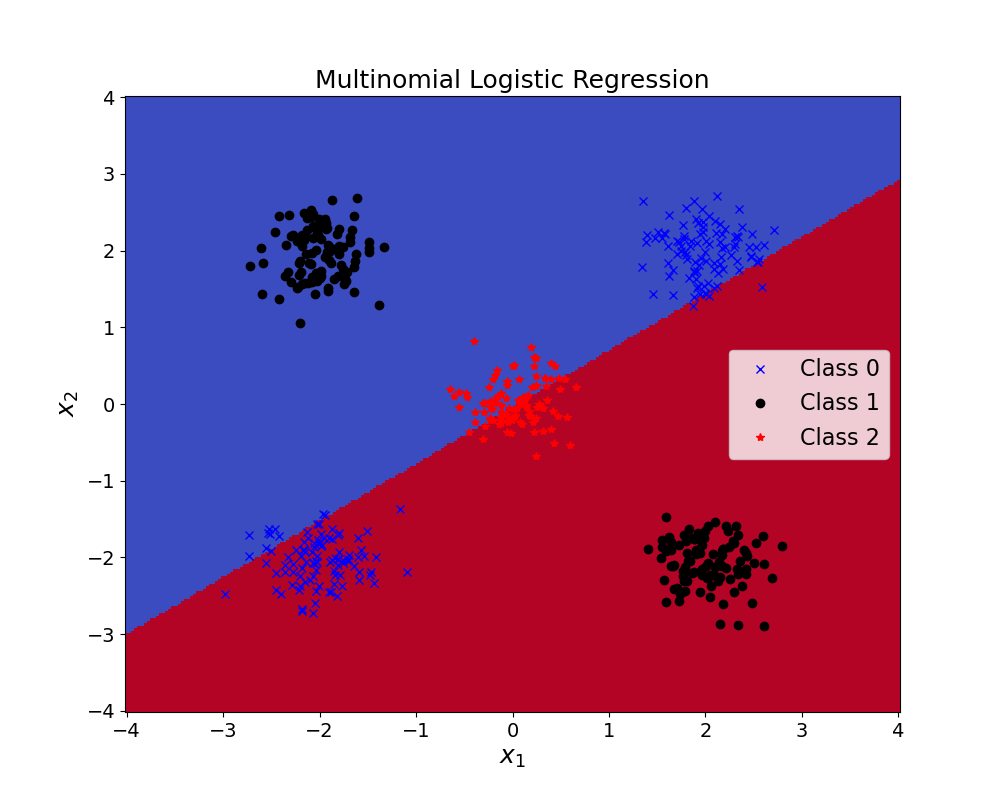

In [6]:
# Create coordinate matrices determined by the sample space
xx, yy = np.meshgrid(np.linspace(-4, 4, 250), np.linspace(-4, 4, 250))

grid = np.c_[xx.ravel(), yy.ravel()]

# Z matrix are the predictions resulting from softmax on the provided model parameters
Z = model.predict(grid).reshape(xx.shape)

plt.figure(figsize=(10,8))

# uses gray background for black dots
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.coolwarm)

plt.plot(X[y==0, 0], X[y==0, 1], 'bx', label="Class 0")
plt.plot(X[y==1, 0], X[y==1, 1], 'ko', label="Class 1");
plt.plot(X[y==2, 0], X[y==2, 1], 'r*', label="Class 2");
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Multinomial Logistic Regression")
plt.legend()
plt.show()

## Multilayer Neural Network

Let's now use [PyTorch](https://pytorch.org/) and put together an MLP that will be capable of separating the classes irrespective of the input's non-linearly separable space.

To begin with, we'll define an MLP class that consists of a single hidden layer (2-layer architecture altogether) with a ReLU activation function:

In [7]:
class TwoLayerMLP(nn.Module):
    # Two-layer MLP (not really a perceptron activation function...) network class
    
    def __init__(self, input_dim, hidden_dim, C):
        super(TwoLayerMLP, self).__init__()
        # Fully connected layer WX + b mapping from input_dim (n) -> hidden_layer_dim
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        # Output layer again fully connected mapping from hidden_layer_dim -> outputs_dim (C)
        self.output_fc = nn.Linear(hidden_dim, C)
        
    # Don't call this function directly!! 
    # Simply pass input to model and forward(input) returns output, e.g. model(X)
    def forward(self, X):
        # X = [batch_size, input_dim (n)]
        X = self.input_fc(X)
        # Non-linear activation function, e.g. ReLU (default good choice)
        # Could also choose F.softplus(x) for smooth-ReLU, empirically worse than ReLU
        X = F.relu(X)
        # X = [batch_size, hidden_dim]
        # Connect to last layer and output 'logits'
        y = self.output_fc(X)
        return y

    
input_dim = X.shape[1]
n_hidden_neurons = 16
output_dim = C

# It's called an MLP but really it's not...
model = TwoLayerMLP(input_dim, n_hidden_neurons, output_dim)
# Visualize network architecture
print(model)

TwoLayerMLP(
  (input_fc): Linear(in_features=2, out_features=16, bias=True)
  (output_fc): Linear(in_features=16, out_features=3, bias=True)
)


Another useful package [torchsummary](https://github.com/sksq96/pytorch-summary) to visualize the neural network architecture:

In [8]:
summary(model, input_size=(16, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 16, 16]              48
            Linear-2                [-1, 16, 3]              51
Total params: 99
Trainable params: 99
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [9]:
def model_train(model, data, labels, criterion, optimizer, num_epochs=25):
    # Apparently good practice to set this "flag" too before training
    # Does things like make sure Dropout layers are active, gradients are updated, etc.
    # Probably not a big deal for our toy network, but still worth developing good practice
    model.train()
    # Optimize the neural network
    for epoch in range(num_epochs):
        # These outputs represent the model's predicted probabilities for each class. 
        outputs = model(data)
        # Criterion computes the cross entropy loss between input and target
        loss = criterion(outputs, labels)
        # Set gradient buffers to zero explicitly before backprop
        optimizer.zero_grad()
        # Backward pass to compute the gradients through the network
        loss.backward()
        # GD step update
        optimizer.step()
        
    return model


# Stochastic GD with learning rate and momentum hyperparameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# The nn.CrossEntropyLoss() loss function automatically performs a log_softmax() to 
# the output when validating, on top of calculating the negative log-likelihood using 
# nn.NLLLoss(), while also being more stable numerically... So don't implement from scratch
criterion = nn.CrossEntropyLoss()
num_epochs = 100

# Convert numpy structures to PyTorch tensors, as these are the data types required by the library
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Trained model
model = model_train(model, X_tensor, y_tensor, criterion, optimizer, num_epochs=num_epochs)

Visualize the decision boundary obtained using our 2-layer neural network:

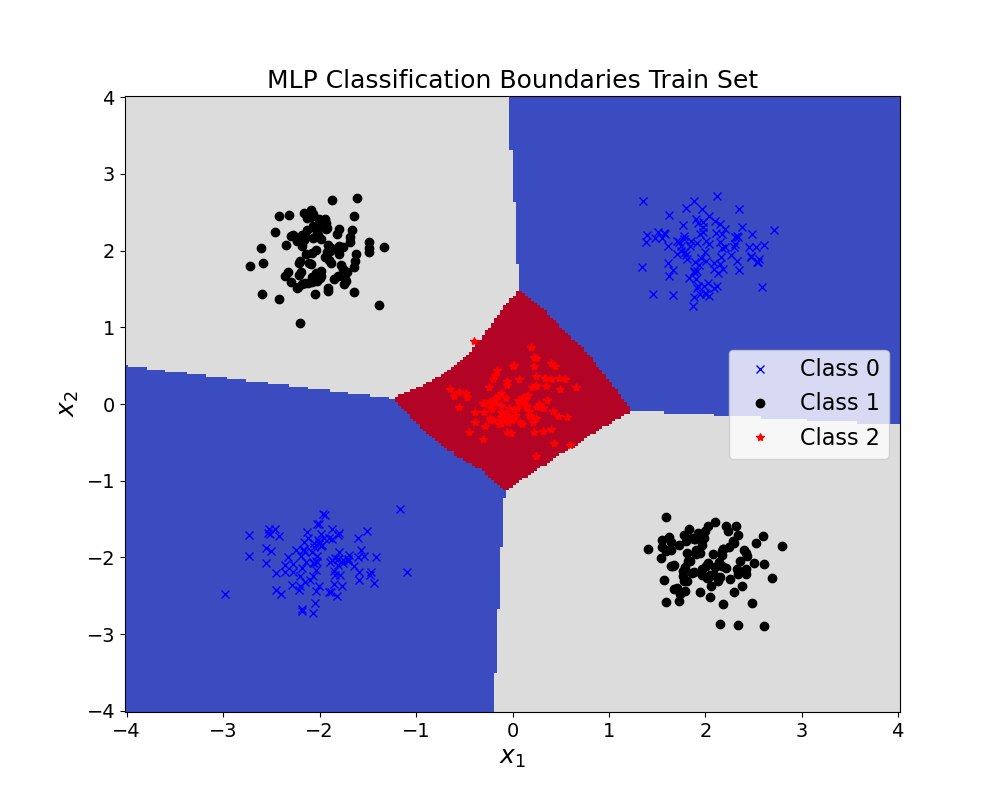

In [10]:
def model_predict(model, data):
    # Similar idea to model.train(), set a flag to let network know your in "inference" mode
    model.eval()
    # Disabling gradient calculation is useful for inference, only forward pass!!
    with torch.no_grad():
        # Evaluate nn on test data and compare to true labels
        predicted_labels = model(data)
        # Back to numpy
        predicted_labels = predicted_labels.detach().numpy()

        return np.argmax(predicted_labels, 1)

# Set up test data as tensor
grid_tensor = torch.FloatTensor(grid)   
# Z matrix are the predictions resulting from the forward pass through the network
Z = model_predict(model, grid_tensor).reshape(xx.shape)

plt.figure(figsize=(10,8))

# uses gray background for black dots
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.coolwarm)
    
plt.plot(X[y==0, 0], X[y==0, 1], 'bx', label="Class 0")
plt.plot(X[y==1, 0], X[y==1, 1], 'ko', label="Class 1");
plt.plot(X[y==2, 0], X[y==2, 1], 'r*', label="Class 2");
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("MLP Classification Boundaries Train Set")
plt.legend()
plt.show()

## PyTorch Pointers

I'm not expert with this library, but here I'll put together some quick pointers in case they're useful for you during HWs and beyond...

### Sequential API

You can write very concise models using the [Sequential API](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html):

In [11]:
# Parameters like n_hidden_neurons set above
quick_two_layer_mlp = nn.Sequential(
    nn.Linear(input_dim, n_hidden_neurons),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons, output_dim)
)

# Forward pass through MLP
probs = quick_two_layer_mlp(X_tensor)
print(probs)

# Backpropagation training insert here

tensor([[-0.3851, -0.7921,  1.0990],
        [-0.3002, -0.7618,  1.0744],
        [-0.2703, -0.7135,  1.0076],
        ...,
        [-0.0545, -0.0536,  0.3820],
        [-0.0392,  0.0049,  0.4558],
        [-0.0438,  0.0385,  0.3771]], grad_fn=<AddmmBackward0>)


### Mini-batch GD

I believe the default "SGD" algorithm unintuitively does **batch** GD (i.e. all $N$ samples updated in one gradient update), as opposed to mini-batch/stochastic GD. I'll show you here one way of configuring your data to chunk it into batches before passing it through the PyTorch optimizers.

In particular, I'll make use of [TensorDatasets](https://pytorch.org/docs/stable/data.html) and [DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which I'll also apply to a newly created test dataset $D_{test}$:

In [12]:
from torch.utils.data import DataLoader, TensorDataset

X_test, y_test = create_data(N=100, noise=0.2)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create your dataset objects
train_data = TensorDataset(X_tensor, y_tensor) 
test_data = TensorDataset(X_test_tensor, y_test_tensor) 

train_dataloader = DataLoader(train_data, batch_size=500, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64) # No need to shuffle...

Let's modify the training and prediction methods to accommodate these dataloaders:

In [13]:
import time

def model_train_loader(model, dataloader, criterion, optimizer):
    size = len(dataloader.dataset)

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        predictions = model(X)
        loss = criterion(predictions, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Report loss every 10 batches
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
            
def model_test_loader(model, dataloader, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Tracking test loss (cross-entropy) and correct classification rate (accuracy)
    test_loss, correct = 0, 0
    
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            predictions = model(X)
            test_loss += criterion(predictions, y)
            correct += (predictions.argmax(1) == y).type(torch.float).sum()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    

# Let's train the Sequential model this time
# And look at how we're training + testing in parallel
# Useful if we wanted to do something like early stopping!
# Nesterov is a better revision of the momentum update
optimizer = torch.optim.SGD(quick_two_layer_mlp.parameters(), lr=0.01, momentum=0.9, nesterov=True)
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_train_loader(quick_two_layer_mlp, train_dataloader, criterion, optimizer)
    model_test_loader(quick_two_layer_mlp, test_dataloader, criterion)

Epoch 1
-------------------------------
loss: 1.288198  [    0/  500]
Test Error: 
 Accuracy: 29.4%, Avg loss: 1.261091 

Epoch 2
-------------------------------
loss: 1.260061  [    0/  500]
Test Error: 
 Accuracy: 31.0%, Avg loss: 1.224006 

Epoch 3
-------------------------------
loss: 1.221833  [    0/  500]
Test Error: 
 Accuracy: 31.8%, Avg loss: 1.179929 

Epoch 4
-------------------------------
loss: 1.176352  [    0/  500]
Test Error: 
 Accuracy: 32.8%, Avg loss: 1.131562 

Epoch 5
-------------------------------
loss: 1.126373  [    0/  500]
Test Error: 
 Accuracy: 35.4%, Avg loss: 1.081379 

Epoch 6
-------------------------------
loss: 1.074411  [    0/  500]
Test Error: 
 Accuracy: 36.6%, Avg loss: 1.031525 

Epoch 7
-------------------------------
loss: 1.022636  [    0/  500]
Test Error: 
 Accuracy: 36.8%, Avg loss: 0.983696 

Epoch 8
-------------------------------
loss: 0.972767  [    0/  500]
Test Error: 
 Accuracy: 56.2%, Avg loss: 0.939100 

Epoch 9
----------------

loss: 0.233099  [    0/  500]
Test Error: 
 Accuracy: 94.8%, Avg loss: 0.277650 

Epoch 72
-------------------------------
loss: 0.229488  [    0/  500]
Test Error: 
 Accuracy: 94.8%, Avg loss: 0.273991 

Epoch 73
-------------------------------
loss: 0.225984  [    0/  500]
Test Error: 
 Accuracy: 95.2%, Avg loss: 0.270432 

Epoch 74
-------------------------------
loss: 0.222582  [    0/  500]
Test Error: 
 Accuracy: 95.4%, Avg loss: 0.266971 

Epoch 75
-------------------------------
loss: 0.219277  [    0/  500]
Test Error: 
 Accuracy: 95.4%, Avg loss: 0.263605 

Epoch 76
-------------------------------
loss: 0.216065  [    0/  500]
Test Error: 
 Accuracy: 95.6%, Avg loss: 0.260328 

Epoch 77
-------------------------------
loss: 0.212942  [    0/  500]
Test Error: 
 Accuracy: 95.8%, Avg loss: 0.257136 

Epoch 78
-------------------------------
loss: 0.209904  [    0/  500]
Test Error: 
 Accuracy: 95.8%, Avg loss: 0.254029 

Epoch 79
-------------------------------
loss: 0.206948  

Observing how we did on the test set:

(62500, 3)


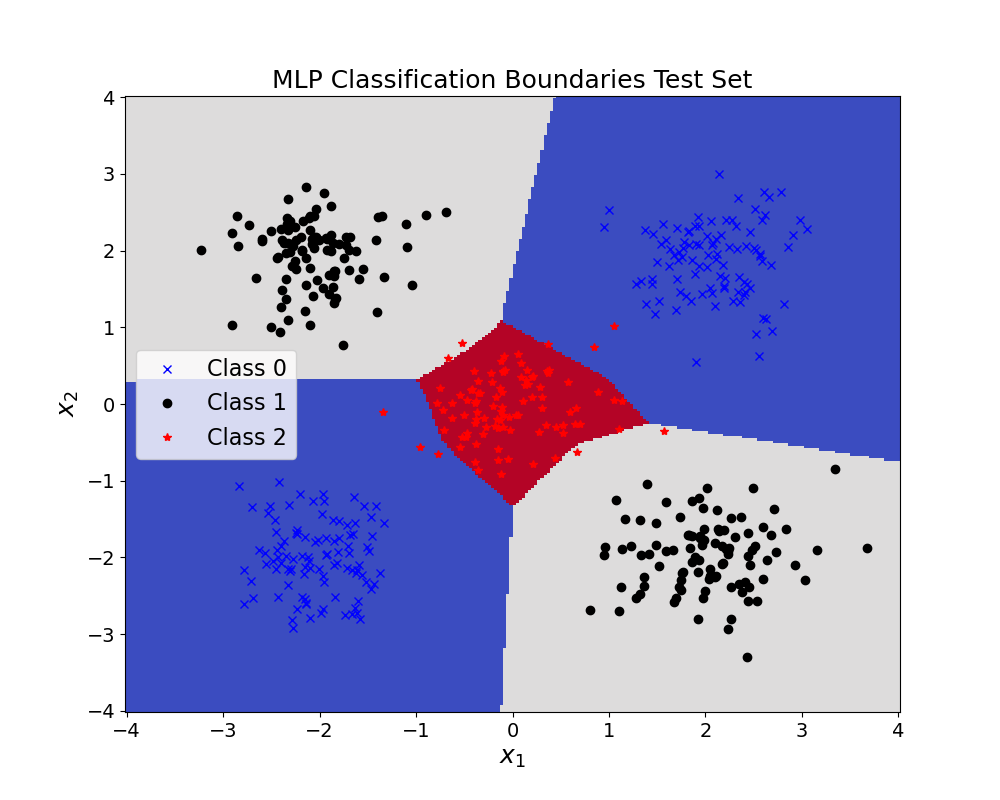

In [14]:
# Z matrix are the predictions resulting from the forward pass through the network
Z_probs = quick_two_layer_mlp(grid_tensor).detach().numpy()
print(Z_probs.shape)
Z_pred = np.argmax(Z_probs, 1).reshape(xx.shape)

fig = plt.figure(figsize=(10,8))

# uses gray background for black dots
plt.pcolormesh(xx, yy, Z_pred, cmap=plt.cm.coolwarm)
    
plt.plot(X_test[y_test==0, 0], X_test[y_test==0, 1], 'bx', label="Class 0")
plt.plot(X_test[y_test==1, 0], X_test[y_test==1, 1], 'ko', label="Class 1");
plt.plot(X_test[y_test==2, 0], X_test[y_test==2, 1], 'r*', label="Class 2");
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("MLP Classification Boundaries Test Set")
plt.legend()
plt.show()

**rant begin** it was unnecessarily difficult to configure the GD batch size using PyTorch, when it should be a far more straightforward process. I lean towards [TensorFlow](https://www.tensorflow.org/)... **rant end**

### Saving & Loading Models

Last bit is that you can easily [save and load models](https://pytorch.org/tutorials/beginner/saving_loading_models.html). First to save to disk (in `.pth` file extension format which is PyTorch convention):

In [15]:
import os

# A state_dict is simply dictionary object that maps each layer to its parameter tensor
# Only the layers with learnable parameters, as wellas the optimizer's detials, e.g. hyperparameters, are stored
# Saving the file 'model.pth' to my current working directory (cwd)
torch.save(model.state_dict(), os.getcwd() + '/model.pth')

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
input_fc.weight 	 torch.Size([16, 2])
input_fc.bias 	 torch.Size([16])
output_fc.weight 	 torch.Size([3, 16])
output_fc.bias 	 torch.Size([3])
Optimizer's state_dict:
state 	 {0: {'momentum_buffer': tensor([[ 0.0454,  0.0209],
        [ 0.2044,  0.2743],
        [ 0.0459, -0.0019],
        [-0.1086, -0.0716],
        [ 0.1152, -0.0804],
        [-0.1170,  0.1299],
        [-0.0956, -0.0378],
        [ 0.0572, -0.0176],
        [ 0.1177, -0.0526],
        [-0.1441,  0.1462],
        [-0.0480,  0.0677],
        [-0.1690,  0.1966],
        [-0.1083, -0.0818],
        [-0.0924, -0.0687],
        [-0.0813, -0.0773],
        [ 0.0904,  0.1960]])}, 1: {'momentum_buffer': tensor([ 0.0578,  0.0654,  0.0014,  0.0945, -0.0369,  0.2247, -0.1463,  0.0369,
        -0.0302, -0.0713, -0.0249,  0.1118,  0.0589,  0.0748,  0.1198,  0.0514])}, 2: {'momentum_buffer': tensor([[ 0.0202, -0.2658,  0.0337, -0.1292,  0.0964,  0.0403,  0.2579,  0.0269,
          0.0793,  0.0817,  0.0435,  0.0

And then to load and run inference from model saved to disk:

In [16]:
# Model class has to be defined somewhere in script before loading from disk
load_model = TwoLayerMLP(input_dim, n_hidden_neurons, output_dim)
load_model.load_state_dict(torch.load(os.getcwd() + '/model.pth'))
load_model.eval()

# Double check test set accuracy
predictions = load_model(X_test_tensor)
correct = (predictions.argmax(1) == y_test_tensor).type(torch.float).sum() / X_test_tensor.shape[0]
print("Model loaded from disk has correct classification accuracy of: {:.1f}%".format(correct.item()*100))

Model loaded from disk has correct classification accuracy of: 97.6%


## References

XOR gate code adapted from <i>"xor_heaviside.ipynb"</i> and <i>"logreg_multiclass_demo"</i> at:

@book{pml1Book,<br>
&emsp; author = "Kevin P. Murphy",<br>
&emsp; title = "Probabilistic Machine Learning: An introduction",<br>
&emsp; publisher = "MIT Press",<br>
&emsp; year = 2022,<br>
&emsp; url = "probml.ai"<br>
}